In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torch.nn.functional as F

In [2]:
import sys

sys.path.append('../../IPYNB/DataPreparation')

from Preparation import CustomDataLoader

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        # Define pooling layers
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Define 1x1 convolutional layer
        self.conv = nn.Conv2d(in_channels * 2, 1, kernel_size=1)
        
        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute average and max pooled representations
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        
        # Concatenate average and max pooled representations
        pooled_features = torch.cat((avg_out, max_out), dim=1)
        
        # Apply 1x1 convolutional layer
        conv_out = self.conv(pooled_features)
        
        # Apply sigmoid activation
        attn_scores = self.sigmoid(conv_out)

        # Apply attention weights to the input features
        attn_output = x * attn_scores

        return attn_output, attn_scores



# Define the architecture of the model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.spatial_attention = SpatialAttention(in_channels=64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Apply spatial attention
        x, _ = self.spatial_attention(x)

        x = x.view(-1, 64 * 8 * 8)  # Reshape to (batch, features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Instantiate your model
model = CustomModel().cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('../../models/05-25-2024/best_model.pt'))

<All keys matched successfully>

In [11]:
# Define F2 Evaluation score
def f2_score(precision, recall):
    
    # Beta value for F2 score
    beta = 2
    
    # F2 score formula
    f2_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    
    return f2_score


In [6]:
# training data properties
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
BATCH_SIZE = 4

In [7]:
test_loader = CustomDataLoader(data_path="../../all_data/data", batch_size=BATCH_SIZE, dataset_type="test", mean=MEAN, std=STD).data_loader

#### Test 1

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time

# Predict the classes for the test dataset
predicted_classes = []
y_true = []
total_inference_time = 0  # To keep track of the total inference time
num_images = 0  # To count the number of images processed

with torch.no_grad():
    for data, target in test_loader:
        # Move data to GPU
        data = data.cuda()
        
        # Record the start time before processing the batch
        start_time = time.time()
        
        # Model inference for the entire batch
        output = model(data)
        
        # Record the end time after the batch inference
        end_time = time.time()
        
        # Calculate inference time for the batch and add to total
        total_inference_time += (end_time - start_time)
        
        # Get the predicted classes
        _, predicted = torch.max(output.data, 1)
        
        # Append predicted classes
        predicted_classes.extend(predicted.cpu().tolist())  # Move to CPU before converting to list
        
        # Append true labels
        y_true.extend(target.cpu().tolist())  # Move target to CPU before converting to list
        
        # Update the total number of images
        num_images += data.size(0)

# Calculate the average inference time per image
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image: {average_inference_time:.6f} seconds")

# Calculate different metrics
accuracy = accuracy_score(y_true, predicted_classes)
precision = precision_score(y_true, predicted_classes, average='weighted')
recall = recall_score(y_true, predicted_classes, average='weighted')
f2 = f2_score(precision, recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F2-score:', f2)


Average inference time per image: 0.000773 seconds
Accuracy: 0.5909090909090909
Precision: 0.5916666666666667
Recall: 0.5909090909090909
F2-score: 0.5910604508196722


<Figure size 600x600 with 0 Axes>

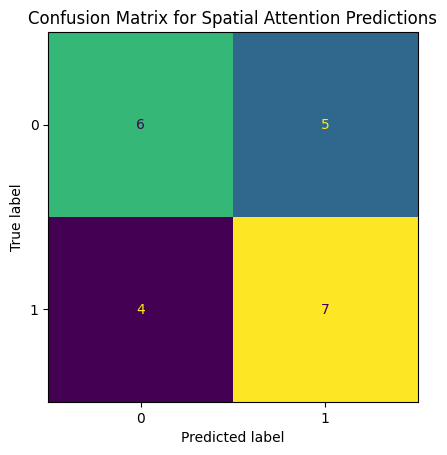

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

spatial_conf_matrix = confusion_matrix(y_true, predicted_classes)

# Plot confusion matrix for Spatial Attention
plt.figure(figsize=(6, 6))
vgg_disp = ConfusionMatrixDisplay(confusion_matrix=spatial_conf_matrix)
vgg_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for Spatial Attention Predictions")
plt.show()

#### Test 2

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predict the classes for the test dataset
predicted_classes = []
y_true = []
total_inference_time = 0  # To keep track of the total inference time
num_images = 0  # To count the number of images processed

with torch.no_grad():
    for data, target in test_loader:
        # Move data to GPU
        data = data.cuda()
        
        # Record the start time before processing the batch
        start_time = time.time()
        
        # Model inference for the entire batch
        output = model(data)
        
        # Record the end time after the batch inference
        end_time = time.time()
        
        # Calculate inference time for the batch and add to total
        total_inference_time += (end_time - start_time)
        
        # Get the predicted classes
        _, predicted = torch.max(output.data, 1)
        
        # Append predicted classes
        predicted_classes.extend(predicted.cpu().tolist())  # Move to CPU before converting to list
        
        # Append true labels
        y_true.extend(target.cpu().tolist())  # Move target to CPU before converting to list
        
        # Update the total number of images
        num_images += data.size(0)

# Calculate the average inference time per image
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image: {average_inference_time:.6f} seconds")

# Calculate different metrics
accuracy = accuracy_score(y_true, predicted_classes)
precision = precision_score(y_true, predicted_classes, average='weighted')
recall = recall_score(y_true, predicted_classes, average='weighted')
f2 = f2_score(precision, recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F2-score:', f2)


Average inference time per image: 0.000632 seconds
Accuracy: 0.6363636363636364
Precision: 0.6363636363636364
Recall: 0.6363636363636364
F2-score: 0.6363636363636365


<Figure size 600x600 with 0 Axes>

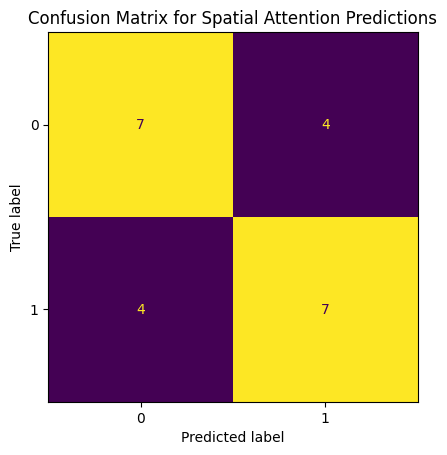

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

spatial_conf_matrix = confusion_matrix(y_true, predicted_classes)

# Plot confusion matrix for Spatial Attention
plt.figure(figsize=(6, 6))
vgg_disp = ConfusionMatrixDisplay(confusion_matrix=spatial_conf_matrix)
vgg_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for Spatial Attention Predictions")
plt.show()

#### Test 3

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predict the classes for the test dataset
predicted_classes = []
y_true = []
total_inference_time = 0  # To keep track of the total inference time
num_images = 0  # To count the number of images processed

with torch.no_grad():
    for data, target in test_loader:
        # Move data to GPU
        data = data.cuda()
        
        # Record the start time before processing the batch
        start_time = time.time()
        
        # Model inference for the entire batch
        output = model(data)
        
        # Record the end time after the batch inference
        end_time = time.time()
        
        # Calculate inference time for the batch and add to total
        total_inference_time += (end_time - start_time)
        
        # Get the predicted classes
        _, predicted = torch.max(output.data, 1)
        
        # Append predicted classes
        predicted_classes.extend(predicted.cpu().tolist())  # Move to CPU before converting to list
        
        # Append true labels
        y_true.extend(target.cpu().tolist())  # Move target to CPU before converting to list
        
        # Update the total number of images
        num_images += data.size(0)

# Calculate the average inference time per image
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image: {average_inference_time:.6f} seconds")

# Calculate different metrics
accuracy = accuracy_score(y_true, predicted_classes)
precision = precision_score(y_true, predicted_classes, average='weighted')
recall = recall_score(y_true, predicted_classes, average='weighted')
f2 = f2_score(precision, recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F2-score:', f2)


Average inference time per image: 0.000497 seconds
Accuracy: 0.7272727272727273
Precision: 0.7272727272727273
Recall: 0.7272727272727273
F2-score: 0.7272727272727272


<Figure size 600x600 with 0 Axes>

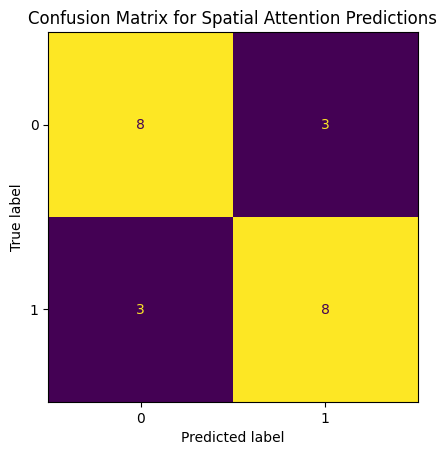

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

spatial_conf_matrix = confusion_matrix(y_true, predicted_classes)

# Plot confusion matrix for Spatial Attention
plt.figure(figsize=(6, 6))
vgg_disp = ConfusionMatrixDisplay(confusion_matrix=spatial_conf_matrix)
vgg_disp.plot(cmap="viridis", colorbar=False)
plt.title("Confusion Matrix for Spatial Attention Predictions")
plt.show()